In [ ]:
# https://github.com/foamliu/Transformer-v2  真大佬

In [ ]:
! git clone https://github.com/dlxj/NTU_MachineLearning.git

Cloning into 'NTU_MachineLearning'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1094 (delta 11), reused 28 (delta 8), pack-reused 1059
Receiving objects: 100% (1094/1094), 290.81 MiB | 37.41 MiB/s, done.
Resolving deltas: 100% (221/221), done.
Checking out files: 100% (774/774), done.


training dataset size: 18000
validation dataset size: 500
Now teacher forcing setting plot


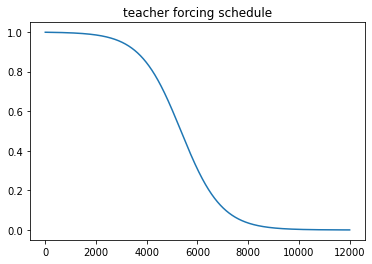

 train [300] loss: 4.347, Perplexity: 77.236, teach: 0.998       

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 val [300] loss: 6.155, Perplexity: 470.836, blue score: 0.208       
1
 val [600] loss: 6.257, Perplexity: 521.492, blue score: 0.251       
1
 val [900] loss: 5.567, Perplexity: 261.715, blue score: 0.290       
1
 val [1200] loss: 5.474, Perplexity: 238.419, blue score: 0.300       
1
 val [1500] loss: 5.251, Perplexity: 190.827, blue score: 0.320       
1
 val [1800] loss: 5.089, Perplexity: 162.165, blue score: 0.330       
1
 val [2100] loss: 5.043, Perplexity: 154.877, blue score: 0.340       
1
 val [2400] loss: 5.040, Perplexity: 154.480, blue score: 0.342       
1
 val [2700] loss: 4.755, Perplexity: 116.113, blue score: 0.352       
1
 val [3000] loss: 4.836, Perplexity: 125.924, blue score: 0.368       
1
 val [3300] loss: 4.446, Perplexity: 85.263, blue score: 0.377       
1
 val [3600] loss: 4.272, Perplexity: 71.685, blue score: 0.373       
1
 val [3900] loss: 4.251, Perplexity: 70.149, blue score: 0.387       
1
 val [4200] loss: 3.992, Perplexity: 54.166, blue score: 

In [ ]:
# ! git clone https://github.com/dlxj/NTU_MachineLearning.git

import os
os.chdir('/content/NTU_MachineLearning/') # HW8_Seq2Seq

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as torch_data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

# import nltk
from nltk.translate.bleu_score import sentence_bleu
# from nltk.translate.bleu_score import SmoothingFunction

import numpy as np
import sys
import os
import random
import json
import heapq as pq
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判斷是用 CPU 還是 GPU 執行運算

import numpy as np

def get_dictionary(data_path, language):
    # 載入字典
    with open(os.path.join(data_path, f'word2int_{language}.json'), "r", encoding='UTF-8') as f:
      word2int = json.load(f)
    with open(os.path.join(data_path, f'int2word_{language}.json'), "r", encoding='UTF-8') as f:
      int2word = json.load(f)
    return word2int, int2word

def Data(data_path, type='training'):
    data = []
    with open(os.path.join(data_path, f'{type}.txt'), "r", encoding='UTF-8') as f:
      for line in f:
        data.append(line)
    print (f'{type} dataset size: {len(data)}')
    return data

class LabelTransform(object):
  def __init__(self, size, pad):
    self.size = size
    self.pad = pad

  def __call__(self, label):
    label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
    return label

import re
class TorchDataset(torch_data.Dataset):
  def __init__(self, data):
    self.data = data
        
  def __len__(self):
    return len(self.data)
  def __getitem__(self, Index):
    # 先將中英文分開
    sentences = self.data[Index]
    sentences = re.split('[\t\n]', sentences)
    sentences = list(filter(None, sentences))
    #print (sentences)
    assert len(sentences) == 2

    # 預備特殊字元
    BOS = word2int_en['<BOS>']
    EOS = word2int_en['<EOS>']
    UNK = word2int_en['<UNK>']

    # 在開頭添加 <BOS>，在結尾添加 <EOS> ，不在字典的 subword (詞) 用 <UNK> 取代
    en, cn = [BOS], [BOS]
    # 將句子拆解為 subword 並轉為整數
    sentence = re.split(' ', sentences[0])
    sentence = list(filter(None, sentence))
    #print (f'en: {sentence}')
    for word in sentence:
      en.append(word2int_en.get(word, UNK))
    en.append(EOS)

    # 將句子拆解為單詞並轉為整數
    # e.g. < BOS >, we, are, friends, < EOS > --> 1, 28, 29, 205, 2
    sentence = re.split(' ', sentences[1])
    sentence = list(filter(None, sentence))
    #print (f'cn: {sentence}')
    for word in sentence:
      cn.append(word2int_cn.get(word, UNK))
    cn.append(EOS)

    en, cn = np.asarray(en), np.asarray(cn)

    # 用 <PAD> 將句子補到相同長度
    en, cn = transform(en), transform(cn)
    en, cn = torch.LongTensor(en), torch.LongTensor(cn)

    return en, cn

def infinite_iter(data_loader):
  it = iter(data_loader)
  while True:
    try:
      ret = next(it)
      yield ret
    except StopIteration:
      it = iter(data_loader)

class Encoder(nn.Module):
  def __init__(self, en_vocab_size, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(en_vocab_size, emb_dim)  # 所有单词转换成向量表示，单词总数为en_vocab_size，每个单词用emb_dim 维向量表示
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    # input = [batch size, sequence len, vocab size]
    embedding = self.embedding(input)
    outputs, hidden = self.rnn(self.dropout(embedding))
    # outputs = [batch size, sequence len, hid dim * directions]
    # hidden =  [num_layers * directions, batch size  , hid dim]
    # outputs 是最上層RNN的輸出
        
    return outputs, hidden

class Attention(nn.Module):
  def __init__(self, hid_dim):
    super(Attention, self).__init__()
    self.hid_dim = hid_dim
    self.attn = nn.Linear((hid_dim * 2) + (hid_dim * 2), hid_dim)
    self.v = nn.Linear(hid_dim, 1, bias = False)
  
  def forward(self, encoder_outputs, decoder_hidden):
    # encoder_outputs = [batch size, sequence len, hid dim * directions]
    # decoder_hidden = [num_layers, batch size, hid dim]
    # 一般來說是取 Encoder 最後一層的 hidden state 來做 attention
    # num_layers = 3
    # TODO
    src_len = encoder_outputs.shape[1]
    decoder_hidden = decoder_hidden[0] + decoder_hidden[1] + decoder_hidden[2]
    decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

    energy = torch.tanh(self.attn(torch.cat((encoder_outputs, decoder_hidden), dim = 2)))
    attention = self.v(energy).squeeze(2)
    
    return F.softmax(attention, dim = 1)

class Decoder(nn.Module):
  def __init__(self, cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
    super().__init__()
    self.cn_vocab_size = cn_vocab_size
    self.hid_dim = hid_dim * 2
    self.n_layers = n_layers
    self.embedding = nn.Embedding(cn_vocab_size, emb_dim)
    self.isatt = isatt
    self.attention = Attention(hid_dim)
    # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
    # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
    # self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
    self.input_dim = emb_dim
    if isatt == False:
        self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
    else:
        self.rnn = nn.GRU((emb_dim + hid_dim*2), self.hid_dim, n_layers, dropout= dropout, batch_first=True)

    self.embedding2vocab1 = nn.Linear(self.hid_dim, self.hid_dim * 2)
    self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
    self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.cn_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, encoder_outputs):
    # input = [batch size, vocab size]
    # hidden = [batch size, n layers * directions, hid dim]
    # Decoder 只會是單向，所以 directions=1
    input = input.unsqueeze(1)
    embedded = self.dropout(self.embedding(input))
    # embedded = [batch size, 1, emb dim]
    if self.isatt:
        # TODO: 在這裡決定如何使用 Attention，e.g. 相加 或是 接在後面， 請注意維度變化
        attn = self.attention(encoder_outputs, hidden)
        attn = attn.unsqueeze(1)
        weighted = torch.bmm(attn, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

    else:
        output, hidden = self.rnn(embedded, hidden)
    # output = [batch size, 1, hid dim]
    # hidden = [num_layers, batch size, hid dim]

    # 將 RNN 的輸出轉為每個詞出現的機率
    output = self.embedding2vocab1(output.squeeze(1))
    output = self.embedding2vocab2(output)
    prediction = self.embedding2vocab3(output)
    # prediction = [batch size, vocab size]
    return prediction, hidden

class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
            
  def forward(self, input, target, teacher_forcing_ratio):
    # input  = [batch size, input len, vocab size]
    # target = [batch size, target len, vocab size]
    # teacher_forcing_ratio 是有多少機率使用正確答案來訓練
    batch_size = target.shape[0]
    target_len = target.shape[1]
    vocab_size = self.decoder.cn_vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, target_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      outputs[:, t] = output
      # 決定是否用正確答案來做訓練
      teacher_force = random.random() <= teacher_forcing_ratio
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      # 如果是 teacher force 則用正解訓練，反之用自己預測的單詞做預測
      input = target[:, t] if teacher_force and t < target_len else top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds

  def inference(self, input, target):
    ########
    # TODO #
    ########
    # 在這裡實施 Beam Search
    # 此函式的 batch size = 1  
    # input  = [batch size, input len, vocab size]
    # target = [batch size, target len, vocab size]
    batch_size = input.shape[0]
    input_len = input.shape[1]        # 取得最大字數
    vocab_size = self.decoder.cn_vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, input_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    if BEAM_SEARCH == False:
      preds = []
      for t in range(1, input_len):
        output, hidden = self.decoder(input, hidden, encoder_outputs)
        # 將預測結果存起來
        outputs[:, t] = output
        # 取出機率最大的單詞
        top1 = output.argmax(1)
        input = top1
        preds.append(top1.unsqueeze(1))
      preds = torch.cat(preds, 1)
      return outputs, preds
    else:
      if BEAM_WIDTH <= 1:
        print('BEAM_WIDTH <= 1 !!')
      
      preds = []
      for t in range(1, input_len):
        if t == 1:
          # first
          output, hidden = self.decoder(input, hidden, encoder_outputs)
          outputs[:,t] = output
          output = F.log_softmax(output, dim = 1)
          log_prob, indexs = torch.topk(output, BEAM_WIDTH)

          for k, (log_p, idx) in enumerate(zip(log_prob[0], indexs[0])):
            idx = idx.view(1)
            pq.heappush(preds, [-log_p.clone().item(), [idx], hidden.clone(), outputs.clone()])
        
        else:
          temp = []
          for i in range(BEAM_WIDTH):
            cur_p, cur_tokens, cur_hidden, cur_outputs = preds[i]
            input = cur_tokens[-1]
            output, cur_hidden = self.decoder(input, cur_hidden, encoder_outputs)
            cur_outputs[:,t] = output
            output = F.log_softmax(output, dim = 1)
            log_prob, indexs = torch.topk(output, BEAM_WIDTH)
            # print(log_prob)

            for j, (log_p, idx) in enumerate(zip(log_prob[0], indexs[0])):
              temp_p = cur_p
              idx = idx.view(1)
              tmp_token = cur_tokens + [idx]
              temp_p -= log_p.item()
              pq.heappush(temp, [temp_p, tmp_token, cur_hidden.clone(), cur_outputs.clone()])

          preds = [pq.heappop(temp) for i in range(BEAM_WIDTH)]
          # print(len(preds))
          # print(len(preds[0]))
          del temp
      
      preds = pq.heappop(preds)
      _, preds, _, outputs= preds
      preds = torch.LongTensor(preds).view(1, len(preds))
      return outputs, preds

def schedule_sampling(step, t_step, mode):
    ########
    # TODO #
    ########
    # teach force
    # 請在這裡直接 return 0 來取消 Teacher Forcing
    # 請在這裡實作 schedule_sampling 的策略
    try:
      mode, h_para = mode
    except:
      mode = MODE[0]
    
    if mode == 'Naive':
      return TEACHER_FORCE_RATE
    elif mode == 'Linear':
      decrement = 1/t_step
      return 1- decrement * step
    elif mode == 'Exponential': # 0.999 
      return h_para**step
    elif mode == 'Inverse_Sigmoid':
      return h_para / (h_para + np.exp(step/h_para)) # 800

def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
  model.train()
  model.zero_grad()
  losses = []
  loss_sum = 0.0

  for step in range(summary_steps):
    now_tf = schedule_sampling(total_steps + step, num_steps, MODE)
    sources, targets = next(train_iter)
    sources, targets = sources.to(device), targets.to(device)
    outputs, preds = model(sources, targets, now_tf)
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)
    loss = loss_function(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    loss_sum += loss.item()
    if (step + 1) % 5 == 0:
      loss_sum = loss_sum / 5
      print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}, teach: {:.3f}      ".format(total_steps + step + 1, loss_sum, np.exp(loss_sum), now_tf), end=" ")
      losses.append(loss_sum)
      loss_sum = 0.0

  return model, optimizer, losses

def tokens2sentence(outputs, int2word):
  sentences = []
  for tokens in outputs:
    sentence = []
    for token in tokens:
      word = int2word[str(int(token))]
      if word == '<EOS>':
        break
      sentence.append(word)
    sentences.append(sentence)
  
  return sentences



def computebleu(sentences, targets):
  score = 0 
  assert (len(sentences) == len(targets))

  def cut_token(sentence):
    tmp = []
    for token in sentence:
      if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
        tmp.append(token)
      else:
        tmp += [word for word in token]
    return tmp 

  for sentence, target in zip(sentences, targets):
    sentence = cut_token(sentence)
    target = cut_token(target)
    score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
  
  return score

def test(model, dataloader, loss_function):
  model.eval()
  loss_sum, bleu_score= 0.0, 0.0
  n = 0
  result = []
  for sources, targets in dataloader:
    sources, targets = sources.to(device), targets.to(device)
    batch_size = sources.size(0)
    outputs, preds = model.inference(sources, targets)
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)

    loss = loss_function(outputs, targets)
    loss_sum += loss.item()

    # 將預測結果轉為文字
    targets = targets.view(sources.size(0), -1)
    preds = tokens2sentence(preds, int2word_cn)
    sources = tokens2sentence(sources, int2word_en)
    targets = tokens2sentence(targets, int2word_cn)
    for source, pred, target in zip(sources, preds, targets):
      result.append((source, pred, target))
    # 計算 Bleu Score
    bleu_score += computebleu(preds, targets)

    n += batch_size

  return loss_sum / len(dataloader), bleu_score / n, result


def save_model(model, optimizer, store_model_path, step):
  torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
  return

def Load_Model(model, load_model_path):
  print(f'Load model from {load_model_path}')
  model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
  return model

if  __name__ == "__main__": 

    input_path = './HW8_Seq2Seq/cmn-eng'
    batch_size = 60
    emb_dim = 256                    # 嵌入向量的维度，即用多少维来表示一个单词
    hid_dim = 512                    # RNN 輸出和隱藏狀態的維度
    n_layers = 3                     # RNN 要疊多少層
    dropout = 0.5                    # dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
    learning_rate = 0.00005
    max_output_len = 50              # 最後輸出句子的最大長度
    num_steps =  12000                # 總訓練次數
    store_steps = 300                # 訓練多少次後須儲存模型
    summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
    load_model = False               # 是否需載入模型
    store_model_path = "./"          # 儲存模型的位置
    load_model_path = None           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
    data_path = input_path           # 資料存放的位置
    attention = True                 # 是否使用 Attention Mechanism


    BEAM_SEARCH = False
    BEAM_WIDTH = 3
    TEACHER_FORCE_RATE = 0.5
    # MODE = ['Linear']
    # MODE = ['Exponential', 0.999]
    MODE = ['Inverse_Sigmoid', 800]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 載入字典
    word2int_en, int2word_en = get_dictionary(data_path, 'en')
    word2int_cn, int2word_cn = get_dictionary(data_path, 'cn')
    
    en_vocab_size = len(word2int_en)
    cn_vocab_size = len(word2int_cn)

    # 加载训练数据


    transform = LabelTransform(max_output_len, word2int_en['<PAD>'])
    

    train_dataset = TorchDataset(Data(data_path, type='training'))
    train_loader = torch_data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    train_iter = infinite_iter(train_loader)

    val_dataset = TorchDataset(Data(data_path, type='validation'))
    val_loader = torch_data.DataLoader(val_dataset, batch_size = 1, shuffle=False)
    
    # 建構模型
    encoder = Encoder(en_vocab_size, emb_dim, hid_dim, n_layers, dropout)
    decoder = Decoder(cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, attention)

    model = Seq2Seq(encoder, decoder, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if load_model:
      model = load_model(model, load_model_path)
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss(ignore_index=0)

    train_losses, val_losses, bleu_scores = [], [], []
    total_steps = 0

    # show the teacher forcing scope for current setting by plot
    tf = []
    print('Now teacher forcing setting plot')
    for i in range(num_steps):
      tf.append(schedule_sampling(i, num_steps, MODE))
    plt.plot(range(num_steps), tf)
    plt.title('teacher forcing schedule')
    plt.show()

    #embedding = nn.Embedding(en_vocab_size, emb_dim)

    while (total_steps < num_steps):
      # 訓練模型
      model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset)
      train_losses += loss
      # 檢驗模型
      val_loss, bleu_score, result = test(model, val_loader, loss_function)
      val_losses.append(val_loss)
      bleu_scores.append(bleu_score)

      total_steps += summary_steps
      print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}       ".format(total_steps, val_loss, np.exp(val_loss), bleu_score))
    
      # 儲存模型和結果
      if total_steps % store_steps == 0 or total_steps >= num_steps:
        print(1)
        save_model(model, optimizer, store_model_path, total_steps)
        with open(f'{store_model_path}/output_{total_steps}.txt', 'w', encoding='UTF-8') as f:
          for line in result:
            print (line, file=f)
    

    load_model_path = f'{store_model_path}/model_{total_steps}'
    print( load_model_path )
    Load_Model(model, load_model_path)
     

    print(2)


